# Load Libraries

In [1]:
import os
os.chdir("..")
from parc import model
from parc import IO
from parc import losses
from parc import graphs
import keras
import numpy as np

# Initialize Parameters

### Adaptable Input Data 

In [9]:
#initialize input data characteristics
data_dir = "C:\\Users\\Austin Leonard\\parc_data\\data\\raw"      #input data file directory
case_numbers = 42   #number of cases
del_t = 0.79        #time step size (ns)
time_steps = 19     #desired time steps for data processing
t_idx = del_t * np.arange(1,time_steps+1)   #time index in nanoseconds

### Adaptable Model Parameters 

In [10]:
#initialize adaptable model parameters
input_size = 240
n_fields=2
numFeatureMaps = 128

#initialize loss parameters
weight_loss = [4,1,1] #initial timestep weights, middle weights, late weights
loss = "mse"
optimizer = keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999)

### Adaptable Post-Processing 

# Initialization

### Parse and Split Data 

In [4]:
#Parse the raw data and return microstructure data and temperature/pressure outputs
data_in, total_output, initial_vals, normalizing_constants = IO.parse_data(data_dir,time_steps,(del_t*(10**-9)))

#np.save("output_data",total_output)
#np.save("input_data",data_in)
#np.save("initial_vals",initial_vals)
#np.save("normalizing_constants.npy",normalizing_constants)

KeyboardInterrupt: 

In [6]:
total_output = np.load("../parc_data/output_data_shorter_time.npy")
data_in = np.load("../parc_data/input_data_shorter_time.npy")
initial_vals = np.load("../parc_data/initial_vals_shorter_time.npy")
normalizing_constants = np.load("../parc_data/normalizing_constants_shorter_time.npy",allow_pickle=True)

In [7]:
# split data set
X_train, y_train, X_train_init, X_val, y_val, X_val_init, test_X, test_Y, test_X_init = IO.split_data(data_in,total_output,initial_vals,splits=[0.6, 0.2, 0.2])

42
25
33
42
(25, 240, 240, 2)
(25, 240, 240, 5, 4)
(25, 240, 240, 2)
(8, 240, 240, 2)
(8, 240, 240, 5, 4)
(8, 240, 240, 2)
(9, 240, 240, 2)
(9, 240, 240, 5, 4)
(9, 240, 240, 2)


### Prepare PARC

In [13]:
#initilize model parameters
parc_model = model.PARC(input_size, n_fields, time_steps, numFeatureMaps) 
parc_model.build()
parc_model.compile(loss = loss,optimizer = optimizer)

# Training

In [14]:
#reshape to match old data format
y_train = IO.reshape_old(y_train)
y_val = IO.reshape_old(y_val)
test_Y = IO.reshape_old(test_Y)

#train the model using training set, skip this part if already trained
history = parc_model.fit(
    x=[X_train, X_train_init],
    y=[y_train[:, :, :, :(time_steps*n_fields)], y_train[:, :, :, (time_steps*n_fields):]],
    validation_data=([X_val, X_val_init], [y_val[:, :, :, :(time_steps*2)], y_val[:, :, :, (time_steps*2):]]),
    batch_size=1,
    epochs=500,
)

Starting shape of data:  (25, 240, 240, 5, 4)
Reformatted data shape:  (25, 240, 240, 20)
Starting shape of data:  (8, 240, 240, 5, 4)
Reformatted data shape:  (8, 240, 240, 20)
Starting shape of data:  (9, 240, 240, 5, 4)
Reformatted data shape:  (9, 240, 240, 20)


In [15]:
#save trained model weights
#parc_model.save_weights("../parc_data/PARC_trained_data.h5")

#load trained model weights
parc_model.load_weights("../parc_data/PARC_trained_data.h5")

# Prediction

In [16]:
#prediction using trained model parameters
pred = parc_model.predict([test_X,test_X_init])

1/1 [==============================] - 97s 97s/step


In [17]:
#reshape to match new data format
test_Y = IO.reshape_new(test_Y)
pred = IO.reshape_new(pred[0],2)

Starting shape of data:  (9, 240, 240, 20)
Reformatted data shape:  (9, 240, 240, 5, 4)
Starting shape of data:  (9, 240, 240, 10)
Reformatted data shape:  (9, 240, 240, 5, 2)


# Losses

In [18]:
#definition of temperature prediction and ground truth with rescaling
norm_T_min = normalizing_constants.item().get('Temperature').get('min')
norm_T_max = normalizing_constants.item().get('Temperature').get('max')
Temp_pred = pred[:,:,:,:,0]
Temp_pred = IO.rescale(Temp_pred,norm_T_min,norm_T_max)
Temp_gt = test_Y[:,:,:,:,0]
Temp_gt = IO.rescale(Temp_gt,norm_T_min,norm_T_max)

#definition of pressure prediction and ground truth with rescaling
norm_P_min = normalizing_constants.item().get('Pressure').get('min')
norm_P_max = normalizing_constants.item().get('Pressure').get('max')
Pres_pred = pred[:,:,:,:,1]
Pres_pred = IO.rescale(Pres_pred,norm_P_min,norm_P_max)
Pres_gt = test_Y[:,:,:,:,1]
Pres_gt = IO.rescale(Pres_gt,norm_P_min,norm_P_max)

In [20]:
#calculate root mean squared, r2 score, and losses for temperature
rmse = losses.rmse(Temp_gt,Temp_pred)
r2 = losses.r2(Temp_gt,Temp_pred)
loss_cv = losses.step_weighted_loss(Temp_gt,Temp_pred,weight_loss)
state_loss = losses.state_weighted_loss(Temp_gt,Temp_pred)

temp loss:  tf.Tensor(
[[[2.57882573e+03 2.12790634e+03 1.75154574e+03 ... 1.16712185e+01
   4.40165021e+01 4.06090870e+01]
  [5.12106520e+01 7.75629705e+02 1.06354657e+03 ... 2.33763957e+00
   1.31362992e-01 1.35968665e+02]
  [3.19432923e+02 3.23290728e+02 7.14455369e+02 ... 3.30249796e+01
   7.94338260e+01 6.48761358e+01]
  ...
  [2.32090421e+02 1.13589023e+02 1.46313441e+02 ... 8.37725269e+00
   1.02344052e+02 1.14544229e+02]
  [8.89132066e+02 4.76307581e+02 7.43480515e+02 ... 6.80799330e+01
   4.60340493e+01 2.07293112e+01]
  [3.98428912e+03 1.10888444e+03 6.10766710e+02 ... 4.60898377e+01
   1.29564562e+00 4.84519408e+01]]

 [[2.96524171e+03 3.11305653e+03 2.52031780e+03 ... 1.23210806e+01
   5.18763139e+01 3.83551589e+01]
  [2.98520561e+02 5.35618871e+01 1.02162295e+02 ... 2.31236988e+00
   4.57342723e-01 1.51026369e+02]
  [9.77212370e+02 2.91203893e+02 4.78665940e+02 ... 4.28705679e+01
   9.58612962e+01 7.36401851e+01]
  ...
  [1.97981153e+03 1.34755003e+03 2.95854857e+02 ... 7.

# Graphs

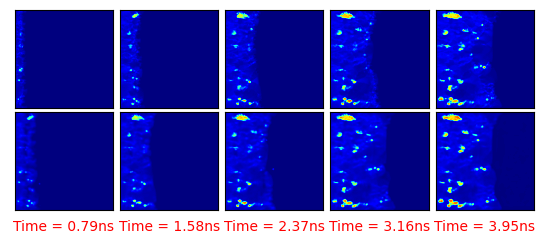

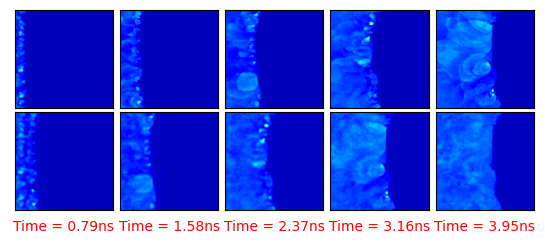

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


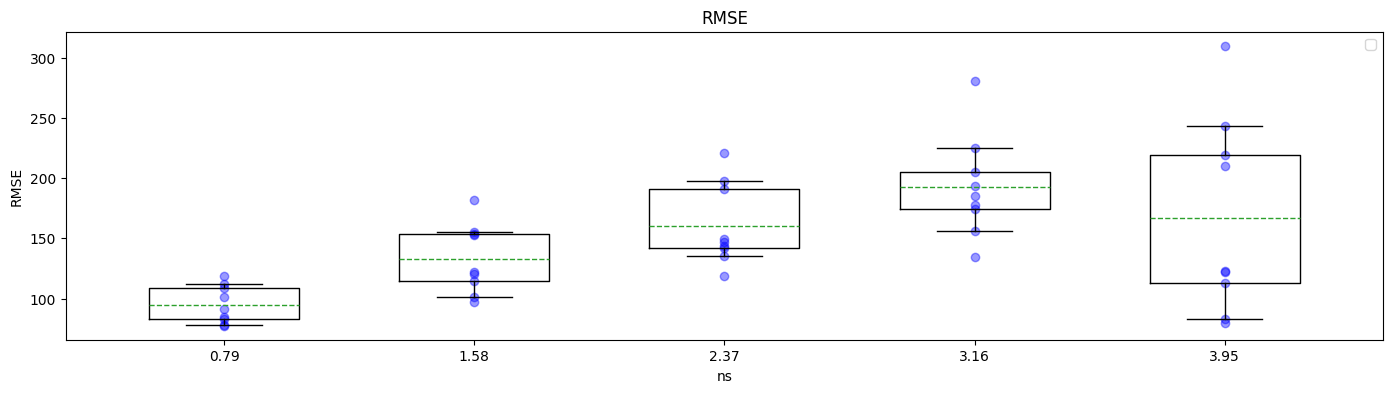

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


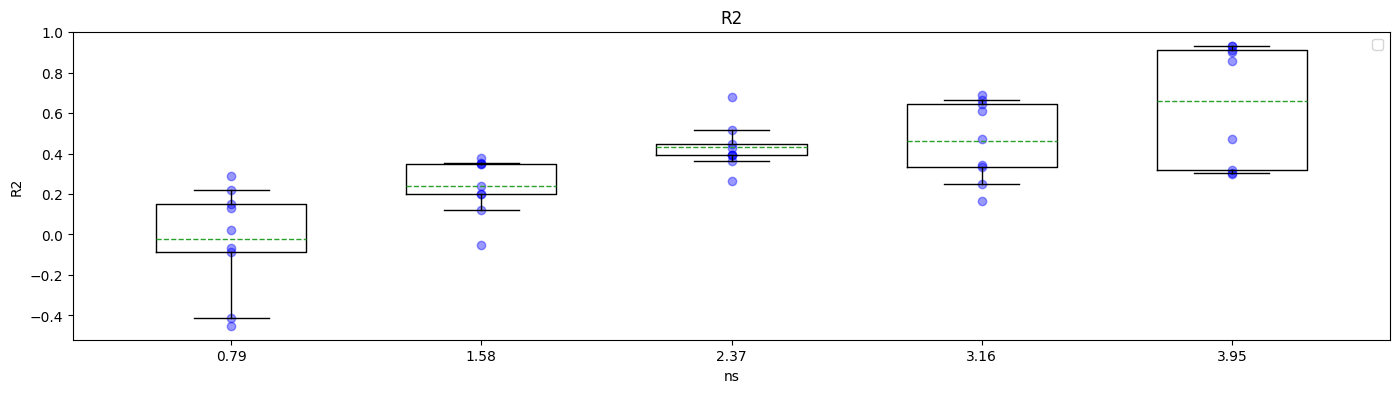

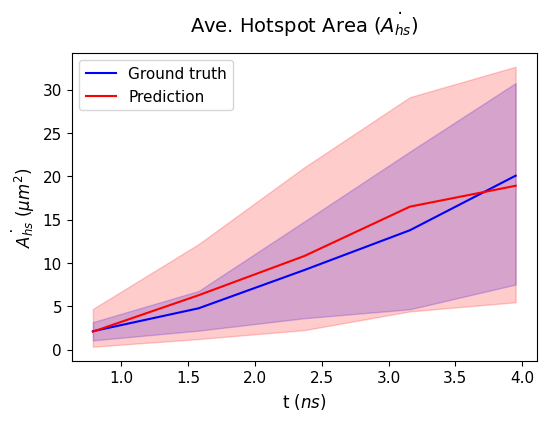

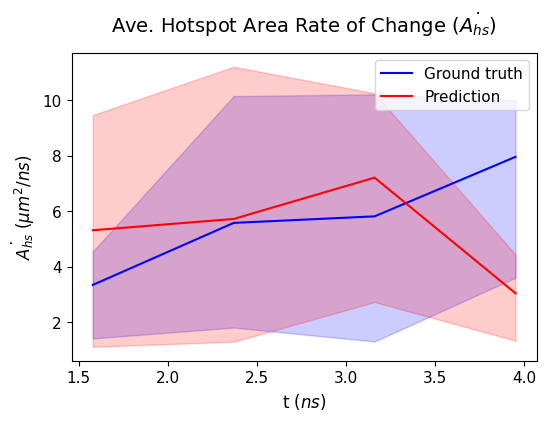

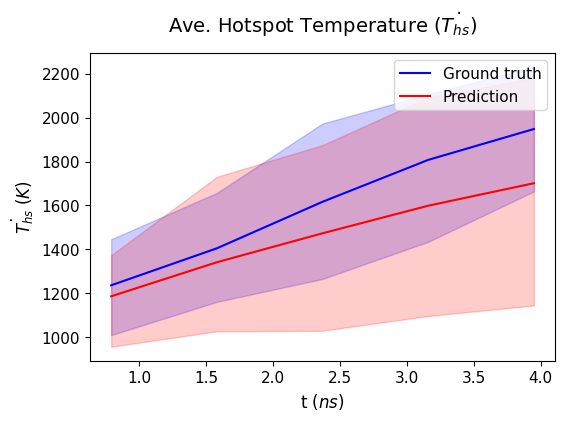

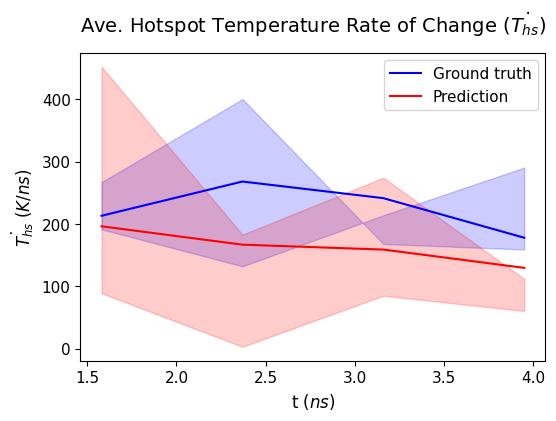

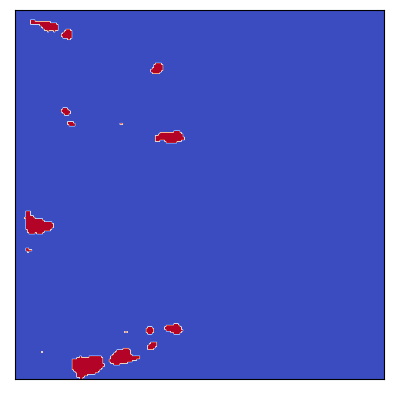

In [59]:
#create plots for data
graphs.visualize_inference(Temp_gt,Temp_pred,t_idx,2,norm_T_min,norm_T_max)
graphs.visualize_inference(Pres_gt,Pres_pred,t_idx,2,norm_P_min,norm_P_max)
graphs.plot_rmse(rmse,t_idx)
graphs.plot_r2(r2,t_idx)
graphs.plot_hotspot_area(Temp_gt,Temp_pred,t_idx)
graphs.plot_hotspot_area_dot(Temp_gt,Temp_pred,t_idx,del_t)
graphs.plot_hotspot_temperature(Temp_gt,Temp_pred,t_idx)
graphs.plot_hotspot_temp_dot(Temp_gt,Temp_pred,t_idx,del_t)
graphs.plot_saliency(Temp_pred,0,2)

# Training with different parameters

## Input data

In [ ]:
#Training data with only temperature field data as input
total_output = np.load("../parc_data/output_data_temp_field.npy")
data_in = np.load("../parc_data/input_data_temp_field.npy")
initial_vals = np.load("../parc_data/initial_vals_temp_field.npy")
normalizing_constants_single = np.load("../parc_data/normalizing_constants_temp_field.npy",allow_pickle=True)

# split data set
X_train_single, y_train_single, X_train_init_single, X_val_single, y_val_single, X_val_init_single, test_X_single, test_Y_single, test_X_init_single = IO.split_data(data_in,total_output,initial_vals,splits=[0.6, 0.2, 0.2])

#Training data with shortened number of time steps
total_output = np.load("../parc_data/output_data_shorter_time.npy")
data_in = np.load("../parc_data/input_data_shorter_time.npy")
initial_vals = np.load("../parc_data/initial_vals_shorter_time.npy")
normalizing_constants_short = np.load("../parc_data/normalizing_constants_shorter_time.npy",allow_pickle=True)

# split data set
X_train_short, y_train_short, X_train_init_short, X_val_short, y_val_short, X_val_init_short, test_X_short, test_Y_short, test_X_init_short = IO.split_data(data_in,total_output,initial_vals,splits=[0.6, 0.2, 0.2])

## Model definition

In [ ]:
#Test model w/ 1 field and full timesteps
parc_model_single_field = model.PARC(240, 1, 19, 128)
parc_model_single_field.build()
parc_model_single_field.compile(loss = loss,loss_weights = loss_weights,optimizer = optimizer,metrics = metrics)
#Test model w/ 2 fields and shortened timesteps
parc_model_short_time = model.PARC(240, 2, 5, 128)
parc_model_short_time.build()
parc_model_short_time.compile(loss = loss,loss_weights = loss_weights,optimizer = optimizer,metrics = metrics)

## Training

In [ ]:
#Training w/ 1 field and full timesteps
history = parc_model_single_field.fit(
    x=[X_train_single, X_train_init_single],
    y=[y_train_single[:, :, :, :19], y_train_single[:, :, :, 19:]],
    validation_data=([X_val_single, X_val_init_single], [y_val_single[:, :, :, :(time_steps)], y_val_single[:, :, :, (time_steps):]]),
    batch_size=1,
    epochs=500,
)
parc_model_single_field.save_weights("../parc_data/singlefieldTrain.h5")
#Training w/ 2 fields and shortened timesteps
history = parc_model_short_time.fit(
    x=[X_train_short, X_train_init_short],
    y=[y_train_short[:, :, :, :(5*2)], y_train_short[:, :, :, (5*2):]],
    validation_data=([X_val_short, X_val_init_short], [y_val_short[:, :, :, :(5*2)], y_val_short[:, :, :, (5*2):]]),
    batch_size=1,
    epochs=500,
)
parc_model_short_time.save_weights("../parc_data/shorttimeTrain.h5")

## Prediction

In [43]:
parc_model_single_field.load_weights("../parc_data/singlefieldTrain.h5")
parc_model_short_time.load_weights("../parc_data/shorttimeTrain.h5")

#prediction for single field training
pred_single = parc_model_single_field.predict([test_X_single,test_X_init_single])

#prediction for shortened timestep training
pred_short = parc_model_short_time.predict([test_X_short,test_X_init_short])

NameError: name 'test_X_single' is not defined

In [ ]:
#reshape to match new data format
test_Y_single = IO.reshape_new(test_Y_single,2)
pred_single = IO.reshape_new(pred_single[0],1)
#reshape to match new data format
test_Y_short = IO.reshape_new(test_Y_short)
pred_short = IO.reshape_new(pred[0]_short,2)

# Graphs

In [ ]:
#single field
norm_T_min = normalizing_constants_single.item().get('Temperature').get('min')
norm_T_max = normalizing_constants_single.item().get('Temperature').get('max')
Temp_pred_single = pred_single[:,:,:,:,0]
Temp_pred_single = IO.rescale(Temp_pred_single,norm_T_min,norm_T_max)
Temp_gt_single = test_Y_single[:,:,:,:,0]
Temp_gt_single = IO.rescale(Temp_gt_single,norm_T_min,norm_T_max)

In [ ]:
#create plots for single field test data
graphs.visualize_inference(Temp_gt_single,Temp_pred_single,t_idx,2,norm_T_min,norm_T_max)
graphs.plot_hotspot_area(Temp_gt_single,Temp_pred_single,t_idx)
graphs.plot_hotspot_area_dot(Temp_gt_single,Temp_pred_single,t_idx,del_t)
graphs.plot_hotspot_temperature(Temp_gt_single,Temp_pred_single,t_idx)
graphs.plot_hotspot_temp_dot(Temp_gt_single,Temp_pred_single,t_idx,del_t)

In [ ]:
#shortened timesteps
norm_T_min = normalizing_constants_short.item().get('Temperature').get('min')
norm_T_max = normalizing_constants_short.item().get('Temperature').get('max')
Temp_pred_short = pred_short[:,:,:,:,0]
Temp_pred_short = IO.rescale(Temp_pred_short,norm_T_min,norm_T_max)
Temp_gt_short = test_Y_short[:,:,:,:,0]
Temp_gt_short = IO.rescale(Temp_gt_short,norm_T_min,norm_T_max)

In [ ]:
#create plots for shortened timestep test data
graphs.visualize_inference(Temp_gt_short,Temp_pred_short,t_idx,2,norm_T_min,norm_T_max)
graphs.plot_hotspot_area(Temp_gt_short,Temp_pred_short,t_idx)
graphs.plot_hotspot_area_dot(Temp_gt_short,Temp_pred_short,t_idx,del_t)
graphs.plot_hotspot_temperature(Temp_gt_short,Temp_pred_short,t_idx)
graphs.plot_hotspot_temp_dot(Temp_gt_short,Temp_pred_short,t_idx,del_t)